In [1]:
# test with data.h5

In [2]:
import csv
import h5py
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from scipy.optimize import fminbound
from hoki.csp.eventrate import CSPEventRate
from hoki.constants import BPASS_EVENT_TYPES, BPASS_METALLICITIES

In [3]:
data = h5py.File(f"./data.h5", "r")
SFH = data['SFH']['TNG']

In [4]:
event_types = ["Ia", "IIP", "II", "Ib", "Ic", "LGRB", "PISNe"]

In [5]:
@np.vectorize
def calc_LB(z, omega0, omega1, hubble):
    '''
    Calculates the lookback time according to Hobbs.

    Parameters:
    z : float
        The redshift at which you want to calculate the lookback
    omega0 : float
        The Matter density parameter (0.3111 Planck 2018)
    omega1 : float
        The dark energy density parameter (0.6889 Planck 2018)
    hubble : float
        The hubble parameters (0.6766 Planck 2018)
    '''
    def func(x):
        E = np.sqrt(omega0*(1+x)**3 + omega1)
        return 1/((1+x)*E)
    # can be simplified by already doing the extra coefficient calculations
    t_hubble = (1/(100*hubble))*3.0856776*10**19
    return t_hubble *scipy.integrate.quad(func, 0, z)[0]/(60*60*24*365.2388526)

In [6]:
met_indicies = ["Z=0.00001", "Z=0.0001", "Z=0.001", "Z=0.002", "Z=0.003", "Z=0.004", "Z=0.006", "Z=0.008", "Z=0.010", 
                "Z=0.014", "Z=0.020", "Z=0.030", "Z=0.040"]
transient_types = ["Type Ia", "CCSN", "LGRB", "PISN"]

In [7]:
# Briel data

In [8]:
h = 0.6766
omega_M = 0.3111
omega_L = 0.6889
lookback_time = calc_LB(SFH.attrs['redshift'], omega_M, omega_L, h) # lookback time into years

In [9]:
SFH_input = SFH[:].reshape(1, SFH.shape[0], SFH.shape[1])*1e9  #Transform SFR from per Myr^-3 to Gpc^-3$
er_csp = CSPEventRate("./BPASS data/", imf="imf135_300", binary=True)

In [10]:
out, edges = er_csp.grid_over_time(SFH_input, lookback_time, event_types , 100, return_time_edges=True)
out = out[0]
edges = edges[:-1]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


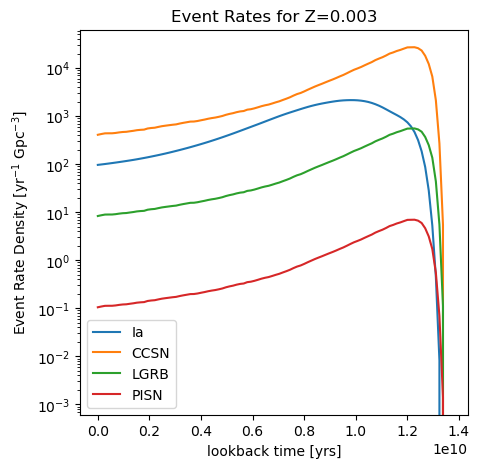

In [11]:
met_index = 4

fig = plt.figure(figsize=(5,5))
plt.plot(edges, out[:,0][met_index], label='Ia')
plt.plot(edges, out[:,1:5][met_index].sum(axis=0), label='CCSN')
plt.plot(edges, out[:,5][met_index], label='LGRB')
plt.plot(edges, out[:,6][met_index], label='PISN')

plt.yscale('log')
#plt.ylim(1e0, 1e6)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
plt.title(r"Event Rates for "+met_indicies[met_index])
plt.legend()
plt.show()

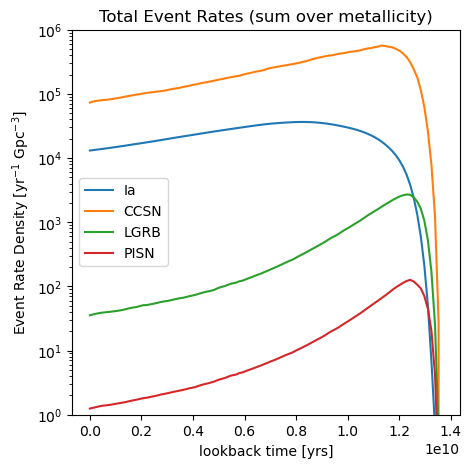

In [12]:
fig = plt.figure(figsize=(5,5))
plt.plot(edges, np.sum(out[:,0], axis=0), label='Ia')
plt.plot(edges, np.sum(out[:,1:5], axis=0).sum(axis=0), label='CCSN')
plt.plot(edges, np.sum(out[:,5], axis=0), label='LGRB')
plt.plot(edges, np.sum(out[:,6], axis=0), label='PISN')

plt.yscale('log')
plt.ylim(1e0, 1e6)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
plt.title(r"Total Event Rates (sum over metallicity)")
plt.legend()
plt.show()

In [13]:
# TNG Data

In [14]:
# TNG cosmology
h = 0.6774
omega_M = 0.3089
omega_L = 0.6911
lookback_time = calc_LB(SFH.attrs['redshift'], omega_M, omega_L, h) # lookback time into years

In [15]:
SFR1 = []
with open('./mass1_metallicity.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR1.append(row)
SFR1_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR1)):
    SFR1_Z[subhalo] = [float(num) for num in SFR1[subhalo]]

for index in range(len(SFR1_Z)):
    SFR1_Z[index] = np.array(SFR1_Z[index])
SFR1_Z = np.array([SFR1_Z])

out1, edges1 = er_csp.grid_over_time(SFR1_Z, lookback_time, event_types , 100, return_time_edges=True)
out1 = out1[0]
edges1 = edges1[:-1]

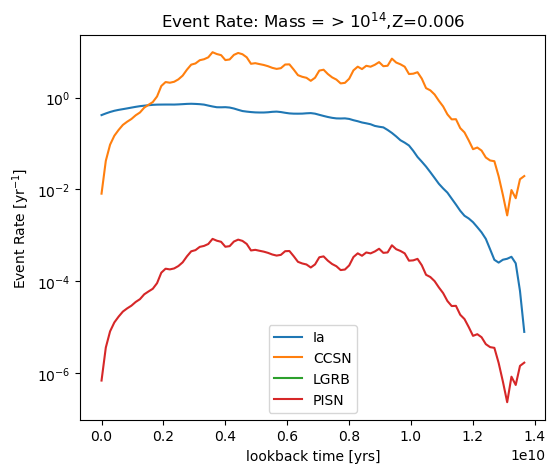

In [16]:
# plotting data for mass1 group

met_index = 6

fig = plt.figure(figsize=(6,5))
plt.plot(edges1,  out1[:,0][met_index], label='Ia')
plt.plot(edges1,  out1[:,1:5][met_index].sum(axis=0), label='CCSN')
plt.plot(edges1,  out1[:,5][met_index], label='LGRB')
plt.plot(edges1,  out1[:,6][met_index], label='PISN')
#plt.plot(edges1,  np.sum(out1[:,0], axis=0), label='Ia')
#plt.plot(edges1,  np.sum(out1[:,1:5], axis=0).sum(axis=0), label='CCSN')
#plt.plot(edges1,  np.sum(out1[:,5], axis=0), label='LGRB')
#plt.plot(edges1,  np.sum(out1[:,6], axis=0), label='PISN')

plt.yscale('log')
#plt.ylim(1e0, 1e6)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate [yr$^{-1}$]")
plt.title(r"Event Rate: Mass = > 10$^{14}$,"+met_indicies[met_index])
#plt.title(r"Event Rate (summed over metallicity)")
plt.legend()
plt.show()

In [17]:
SFR2 = []
with open('./mass2_metallicity.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR2.append(row)
SFR2_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR2)):
    SFR2_Z[subhalo] = [float(num) for num in SFR2[subhalo]]

for index in range(len(SFR2_Z)):
    SFR2_Z[index] = np.array(SFR2_Z[index])
SFR2_Z = np.array([SFR2_Z])

out2, edges2 = er_csp.grid_over_time(SFR2_Z, lookback_time, event_types , 100, return_time_edges=True)
out2 = out2[0]
edges2 = edges2[:-1]

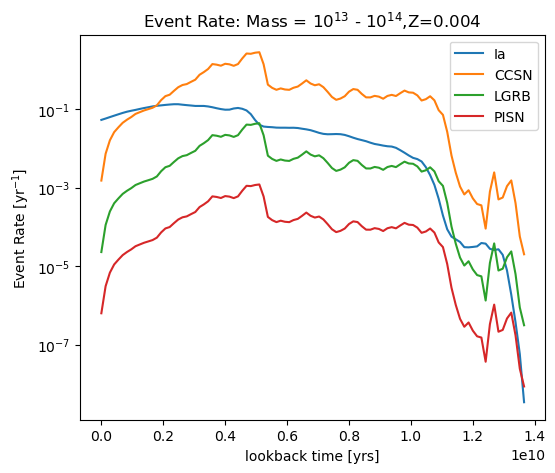

In [18]:
# plotting data for mass2 group

met_index = 5

fig = plt.figure(figsize=(6,5))
plt.plot(edges2,  out2[:,0][met_index], label='Ia')
plt.plot(edges2,  out2[:,1:5][met_index].sum(axis=0), label='CCSN')
plt.plot(edges2,  out2[:,5][met_index], label='LGRB')
plt.plot(edges2,  out2[:,6][met_index], label='PISN')
#plt.plot(edges2,  np.sum(out2[:,0], axis=0), label='Ia')
#plt.plot(edges2,  np.sum(out2[:,1:5], axis=0).sum(axis=0), label='CCSN')
#plt.plot(edges2,  np.sum(out2[:,5], axis=0), label='LGRB')
#plt.plot(edges2,  np.sum(out2[:,6], axis=0), label='PISN')

plt.yscale('log')
#plt.ylim(1e0, 1e6)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate [yr$^{-1}$]")
plt.title(r"Event Rate: Mass = 10$^{13}$ - 10$^{14}$,"+met_indicies[met_index])
#plt.title(r"Event Rate (summed over metallicity)")
plt.legend()
plt.show()

In [19]:
SFR3 = []
with open('./mass3_metallicity.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR3.append(row)
SFR3_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR3)):
    SFR3_Z[subhalo] = [float(num) for num in SFR3[subhalo]]

for index in range(len(SFR3_Z)):
    SFR3_Z[index] = np.array(SFR3_Z[index])
SFR3_Z = np.array([SFR3_Z])

out3, edges3 = er_csp.grid_over_time(SFR3_Z, lookback_time, event_types , 100, return_time_edges=True)
out3 = out3[0]
edges3 = edges3[:-1]

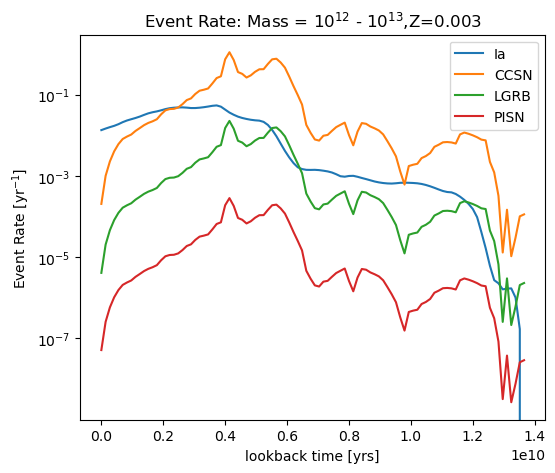

In [20]:
# plotting data for mass3 group

met_index = 4

fig = plt.figure(figsize=(6,5))
plt.plot(edges3,  out3[:,0][met_index], label='Ia')
plt.plot(edges3,  out3[:,1:5][met_index].sum(axis=0), label='CCSN')
plt.plot(edges3,  out3[:,5][met_index], label='LGRB')
plt.plot(edges3,  out3[:,6][met_index], label='PISN')
#plt.plot(edges3,  np.sum(out3[:,0], axis=0), label='Ia')
#plt.plot(edges3,  np.sum(out3[:,1:5], axis=0).sum(axis=0), label='CCSN')
#plt.plot(edges3,  np.sum(out3[:,5], axis=0), label='LGRB')
#plt.plot(edges3,  np.sum(out3[:,6], axis=0), label='PISN')

plt.yscale('log')
#plt.ylim(1e0, 1e6)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate [yr$^{-1}$]")
plt.title(r"Event Rate: Mass = 10$^{12}$ - 10$^{13}$,"+met_indicies[met_index])
#plt.title(r"Event Rate (summed over metallicity)")
plt.legend()
plt.show()

In [21]:
SFR4 = []
with open('./mass4_metallicity.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR4.append(row)
SFR4_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR4)):
    SFR4_Z[subhalo] = [float(num) for num in SFR4[subhalo]]

for index in range(len(SFR4_Z)):
    SFR4_Z[index] = np.array(SFR4_Z[index])
SFR4_Z = np.array([SFR4_Z])

out4, edges4 = er_csp.grid_over_time(SFR4_Z, lookback_time, event_types , 100, return_time_edges=True)
out4 = out4[0]
edges4 = edges4[:-1]

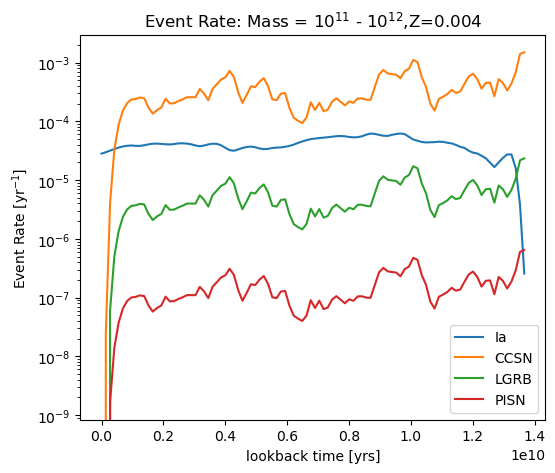

In [22]:
# plotting data for mass4 group

met_index = 5

fig = plt.figure(figsize=(6,5))
plt.plot(edges4,  out4[:,0][met_index], label='Ia')
plt.plot(edges4,  out4[:,1:5][met_index].sum(axis=0), label='CCSN')
plt.plot(edges4,  out4[:,5][met_index], label='LGRB')
plt.plot(edges4,  out4[:,6][met_index], label='PISN')
#plt.plot(edges4,  np.sum(out4[:,0], axis=0), label='Ia')
#plt.plot(edges4,  np.sum(out4[:,1:5], axis=0).sum(axis=0), label='CCSN')
#plt.plot(edges4,  np.sum(out4[:,5], axis=0), label='LGRB')
#plt.plot(edges4,  np.sum(out4[:,6], axis=0), label='PISN')

plt.yscale('log')
#plt.ylim(1e0, 1e6)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate [yr$^{-1}$]")
plt.title(r"Event Rate: Mass = 10$^{11}$ - 10$^{12}$,"+met_indicies[met_index])
#plt.title(r"Event Rate (summed over metallicity)")
plt.legend()
plt.show()

In [23]:
SFR5 = []
with open('./mass5_metallicity.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR5.append(row)
SFR5_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR5)):
    SFR5_Z[subhalo] = [float(num) for num in SFR5[subhalo]]

for index in range(len(SFR5_Z)):
    SFR5_Z[index] = np.array(SFR5_Z[index])
SFR5_Z = np.array([SFR5_Z])

out5, edges5 = er_csp.grid_over_time(SFR5_Z, lookback_time, event_types , 100, return_time_edges=True)
out5 = out5[0]
edges5 = edges5[:-1]

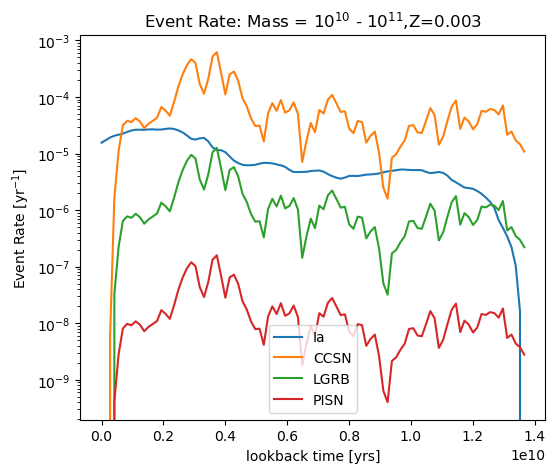

In [24]:
# plotting data for mass5 group

met_index = 4

fig = plt.figure(figsize=(6,5))
plt.plot(edges5,  out5[:,0][met_index], label='Ia')
plt.plot(edges5,  out5[:,1:5][met_index].sum(axis=0), label='CCSN')
plt.plot(edges5,  out5[:,5][met_index], label='LGRB')
plt.plot(edges5,  out5[:,6][met_index], label='PISN')
#plt.plot(edges5,  np.sum(out5[:,0], axis=0), label='Ia')
#plt.plot(edges5,  np.sum(out5[:,1:5], axis=0).sum(axis=0), label='CCSN')
#plt.plot(edges5,  np.sum(out5[:,5], axis=0), label='LGRB')
#plt.plot(edges5,  np.sum(out5[:,6], axis=0), label='PISN')

plt.yscale('log')
#plt.ylim(1e0, 1e6)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate [yr$^{-1}$]")
plt.title(r"Event Rate: Mass = 10$^{10}$ - 10$^{11}$,"+met_indicies[met_index])
#plt.title(r"Event Rate (summed over metallicity)")
plt.legend()
plt.show()

In [25]:
SFR6 = []
with open('./mass6_metallicity.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR6.append(row)
SFR6_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR6)):
    SFR6_Z[subhalo] = [float(num) for num in SFR6[subhalo]]

for index in range(len(SFR6_Z)):
    SFR6_Z[index] = np.array(SFR6_Z[index])
SFR6_Z = np.array([SFR6_Z])

out6, edges6 = er_csp.grid_over_time(SFR6_Z, lookback_time, event_types , 100, return_time_edges=True)
out6 = out6[0]
edges6 = edges6[:-1]

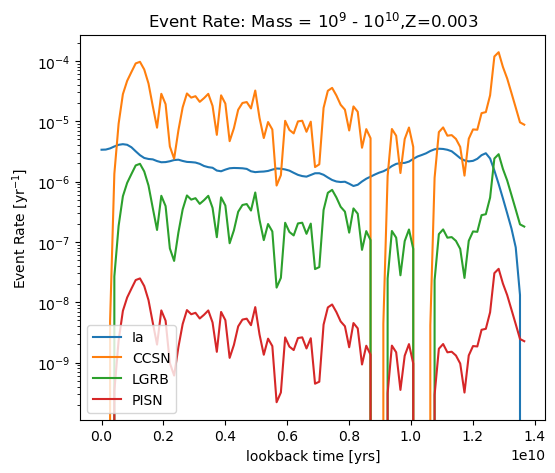

In [26]:
# plotting data for mass6 group

met_index = 4

fig = plt.figure(figsize=(6,5))
plt.plot(edges6,  out6[:,0][met_index], label='Ia')
plt.plot(edges6,  out6[:,1:5][met_index].sum(axis=0), label='CCSN')
plt.plot(edges6,  out6[:,5][met_index], label='LGRB')
plt.plot(edges6,  out6[:,6][met_index], label='PISN')
#plt.plot(edges6,  np.sum(out6[:,0], axis=0), label='Ia')
#plt.plot(edges6,  np.sum(out6[:,1:5], axis=0).sum(axis=0), label='CCSN')
#plt.plot(edges6,  np.sum(out6[:,5], axis=0), label='LGRB')
#plt.plot(edges6,  np.sum(out6[:,6], axis=0), label='PISN')

plt.yscale('log')
#plt.ylim(1e0, 1e6)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate [yr$^{-1}$]")
plt.title(r"Event Rate: Mass = 10$^{9}$ - 10$^{10}$,"+met_indicies[met_index])
#plt.title(r"Event Rate (summed over metallicity)")
plt.legend()
plt.show()

In [27]:
# Comparing transient event rates between masses

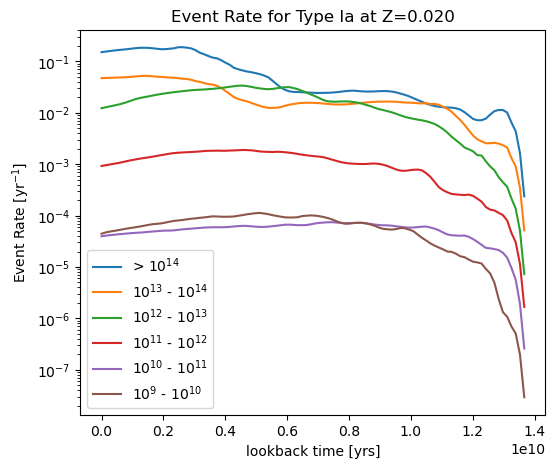

In [28]:
met_index = 10
transient_type = 0

fig = plt.figure(figsize=(6,5))
plt.plot(edges1, out1[:,transient_type][met_index], label='> 10$^{14}$')
plt.plot(edges2, out2[:,transient_type][met_index], label='10$^{13}$ - 10$^{14}$')
plt.plot(edges3, out3[:,transient_type][met_index], label='10$^{12}$ - 10$^{13}$')
plt.plot(edges4, out4[:,transient_type][met_index], label='10$^{11}$ - 10$^{12}$')
plt.plot(edges5, out5[:,transient_type][met_index], label='10$^{10}$ - 10$^{11}$')
plt.plot(edges6, out6[:,transient_type][met_index], label='10$^{9}$ - 10$^{10}$')
#plt.plot(edges1, out1[:,1:5][met_index].sum(axis=0), label='> 10$^{14}$')
#plt.plot(edges2, out2[:,1:5][met_index].sum(axis=0), label='10$^{13}$ - 10$^{14}$')
#plt.plot(edges3, out3[:,1:5][met_index].sum(axis=0), label='10$^{12}$ - 10$^{13}$')
#plt.plot(edges4, out4[:,1:5][met_index].sum(axis=0), label='10$^{11}$ - 10$^{12}$')
#plt.plot(edges5, out5[:,1:5][met_index].sum(axis=0), label='10$^{10}$ - 10$^{11}$')
#plt.plot(edges6, out6[:,1:5][met_index].sum(axis=0), label='10$^{9}$ - 10$^{10}$')
plt.yscale('log')
#plt.xlim(0,15)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate [yr$^{-1}$]")
plt.title(r"Event Rate for "+transient_types[transient_type]+" at "+met_indicies[met_index])
plt.legend()
plt.show()